## Setup Evaluation: Seeding Strategies in Search-Based Unit Test Generation for Python

Provides a part of the setup for the empirical evaluation of the bachelor's thesis: Seeding Strategies in Search-Based Unit Test Generation for Python

**In this Notebook I determine the optimal value for the probability of seeding preexisting testcases.**

In [1]:
# Do all necessary imports here
import itertools as it
import statistics

from bisect import bisect_left
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylatex
import scipy.stats as ss
import seaborn as sns
import glob

from pandas import Categorical
from pylab import savefig
from IPython.display import display, Markdown, display_markdown

### Load Data From CSV Files

In [2]:
def reset_orig_dir():
    os.chdir('/home/l_pc1-l/ba/own_stuff/ba-thesis/evaluation/eval_env/notebooks')

In [3]:
## Combines all csv files in the current directory and recursively to one csv file.
#adjust the below path on your machine
os.chdir("/home/l_pc1-l/ba/own_stuff/ba-thesis/evaluation/results/opt_init/data")
extension = 'csv'
all_filenames = [i for i in glob.glob('./**/*.{}'.format(extension), recursive=True)]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "../results.csv", index=False, encoding='utf-8-sig')

In [4]:
reset_orig_dir()
# The names of the columns we are interested in
cut = "TargetModule"
project_name = "ProjectName"
config = "ConfigurationId"
coverage = "Coverage"
collected_testcases = "CollectedTestCases"
found_testcases = "FoundTestCases"
suitable_test_module = "SuitableTestModule"

# How often every CUT was executed
runs = 1
# Adjust this path on your system if you want to rerun this sheet!
PAPER_EXPORT_PATH = Path("/home/l_pc1-l/ba/own_stuff/ba-thesis/evaluation")

results = pd.read_csv(Path("../..") / "results" / "opt_init" / "results.csv")
project_information = pd.read_csv(Path("../..") / "results" / "opt_init" / "projects.csv")

In [19]:
number_cuts = len(set(results[cut]))
print(f"We tested {number_cuts} unique classes, each being executed {runs} times per configuration")

We tested 105 unique classes, each being executed 1 times per configuration


In [20]:
f_config_names = list(set(results[config]))
config_names = [n for n in f_config_names if type(n) is str]
config_names.sort()
print("I used {} configurations, namely:\n - {}".format(
    len(config_names), "\n - ".join(config_names)
))

I used 13 configurations, namely:
 - Init_Reuse_0.0_Mut_0
 - Init_Reuse_0.3_Mut_0
 - Init_Reuse_0.3_Mut_4
 - Init_Reuse_0.3_Mut_8
 - Init_Reuse_0.5_Mut_0
 - Init_Reuse_0.5_Mut_4
 - Init_Reuse_0.5_Mut_8
 - Init_Reuse_0.7_Mut_0
 - Init_Reuse_0.7_Mut_4
 - Init_Reuse_0.7_Mut_8
 - Init_Reuse_0.9_Mut_0
 - Init_Reuse_0.9_Mut_4
 - Init_Reuse_0.9_Mut_8


### Create a Heatmap and a Table for the Configurations and their achieved Coverage

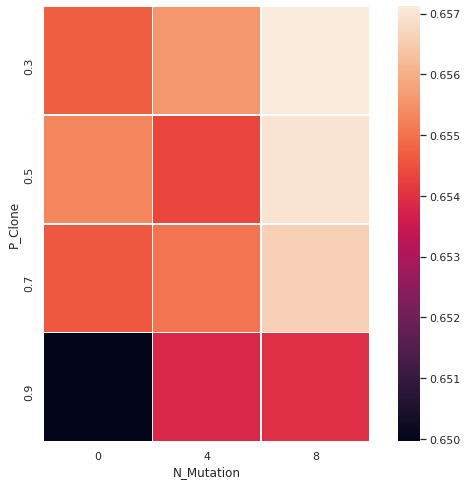

In [59]:
# heatmap for the results
# heatmap must have the coverage values
# on one axis there must be the const seeding values and on the other the dynamic seeding values

raw_table_data = results.groupby(config, as_index=False).agg(
    {
        coverage: "mean"
    }
)
data = [[],[],[],[]]
for r in raw_table_data.iterrows():
    l = r[1].tolist()
    if int(l[0][13]) == 0:
        continue
    if int(l[0][13]) == 3:
        data[0].append(l[1])
    if int(l[0][13]) == 5:
        data[1].append(l[1])
    if int(l[0][13]) == 7:
        data[2].append(l[1])
    if int(l[0][13]) == 9:
        data[3].append(l[1])


x_axis_labels = [0, 4, 8]
y_axis_labels = [0.3, 0.5, 0.7, 0.9]

# set heatmap size
plt.figure(figsize= (10,8)) 
 
# create heatmap seaborn
 
cbar_kws = {"orientation":"vertical", 
            "shrink":1,
           }
seed_map = sns.heatmap(data,
                       xticklabels=x_axis_labels,
                       yticklabels=y_axis_labels,
                       cbar_kws=cbar_kws,
                       linewidth=0.5,
                       square=True
                      )
seed_map.set_xticklabels(seed_map.get_xticklabels(), rotation=0)
plt.xlabel("N_Mutation")
plt.ylabel("P_Clone")
#plt.show()

#write to file
#figure = svm.get_figure()    
plt.savefig("../../../Thesis/images/opt_init_heatmap.pdf", dpi=400)

In [58]:
# Table for the different configurations and their achieved coverage.
table = pylatex.Table(position="H")
tabular = pylatex.Tabular('|c|c|c|', booktabs=True)
tabular.add_row([
    pylatex.NoEscape(r"P\textsubscript{Clone}"),
    pylatex.NoEscape(r"N\textsubscript{Mutations}"),
    "Avg. Branch Coverage"])



raw_table_data = results.groupby(config, as_index=False).agg(
    {
        coverage: "mean",
    }
)
raw_table_data.sort_values(by=coverage, ascending=False, inplace=True)
for _, row in raw_table_data.iterrows():
    tabular.add_row([
        row[config][-9] + "." + row[config][-7],
        row[config][-1],
        "{:.4f}".format(row[coverage]),
    ])

tabular.add_hline()
table.append(pylatex.NoEscape(r'\centering'))
table.append(tabular)
table.add_caption(pylatex.NoEscape(r"The different combinations of P\textsubscript{Clone} and " +
                  r"N\textsubscript{Mutation} and the corresponding achieved coverage."))
label = pylatex.Label("tabinitvalues")
table.append(label)

#adjust this path if you want to store the table on your machine
with open ("../../../Thesis/chapters/evaluation_tables/opt_init_table.tex", "w") as file:
    file.write(table.dumps())
print(table.dumps())

\begin{table}[H]%
\centering%
\begin{tabular}{@{}|c|c|c|@{}}%
\toprule%
P\textsubscript{Clone}&N\textsubscript{Mutations}&Avg. Branch Coverage\\%
0.3&8&0.6571\\%
0.5&8&0.6570\\%
0.7&8&0.6566\\%
0.3&4&0.6556\\%
0.5&0&0.6553\\%
0.7&4&0.6550\\%
0.3&0&0.6547\\%
0.7&0&0.6546\\%
0.5&4&0.6544\\%
0.9&8&0.6540\\%
0.9&4&0.6538\\%
0.9&0&0.6500\\%
0.0&0&0.6447\\%
\midrule\bottomrule%
%
\end{tabular}%
\caption{The different combinations of P\textsubscript{Clone} and N\textsubscript{Mutation} and the corresponding achieved coverage.}%
\label{tabinitvalues}%
\end{table}


In [27]:
# Add a column containing the project name to the evaluation results.
projects = []
for _, row in results.iterrows():
    projects.append(row[cut].split(".")[0])

results.insert(1, "Project", projects, True)
project = "Project"

In [57]:
# Table reporting the collected testcases. This value is needed for a table in the main evaluation.
table = pylatex.Table(position="H")
tabular = pylatex.Tabular('|c|c|c|', booktabs=True)
tabular.add_row([
    "Project",
    "Avg. Branch Coverage",
    "# Collected Testcases"
])



raw_table_data = results.groupby([config,project], as_index=False).agg(
    {
        coverage: "mean",
        "CollectedTestCases": "mean"
    }
)
raw_table_data.sort_values(by=project, ascending=True, inplace=True)
for _, row in raw_table_data.iterrows():
    if row[config][-1] == '8' and row[config][-7] == '3':
        tabular.add_row([
            row[project],
            "{:.4f}".format(row[coverage]),
            row["CollectedTestCases"]
        ])

tabular.add_hline()
table.append(pylatex.NoEscape(r'\centering'))
table.append(tabular)
table.add_caption(pylatex.NoEscape(r"The different combinations of P\textsubscript{Clone} and " +
                  r"N\textsubscript{Mutations} and the corresponding achieved coverage."))
label = pylatex.Label("tabinitvalues")
table.append(label)

#adjust this path if you want to store the table on your machine
with open ("../../../Thesis/chapters/evaluation_tables/helper_table.tex", "w") as file:
    file.write(table.dumps())
print(table.dumps())

\begin{table}[H]%
\centering%
\begin{tabular}{@{}|c|c|c|@{}}%
\toprule%
Project&Avg. Branch Coverage&\# Collected Testcases\\%
apimd&0.2627&nan\\%
async\_btree&0.3357&3.0\\%
codetiming&0.9235&nan\\%
docstring\_parser&0.5271&0.5\\%
flutes&0.4259&2.4516129032258065\\%
flutils&0.4952&6.873239436619718\\%
mimesis&0.8769&10.49800796812749\\%
pypara&0.3887&18.0\\%
pytutils&0.6042&nan\\%
string\_utils&0.8647&nan\\%
\midrule\bottomrule%
%
\end{tabular}%
\caption{The different combinations of P\textsubscript{Clone} and N\textsubscript{Mutations} and the corresponding achieved coverage.}%
\label{tabinitvalues}%
\end{table}
